
<h1><center>Data Wrangling and Cleanup</center></h1>

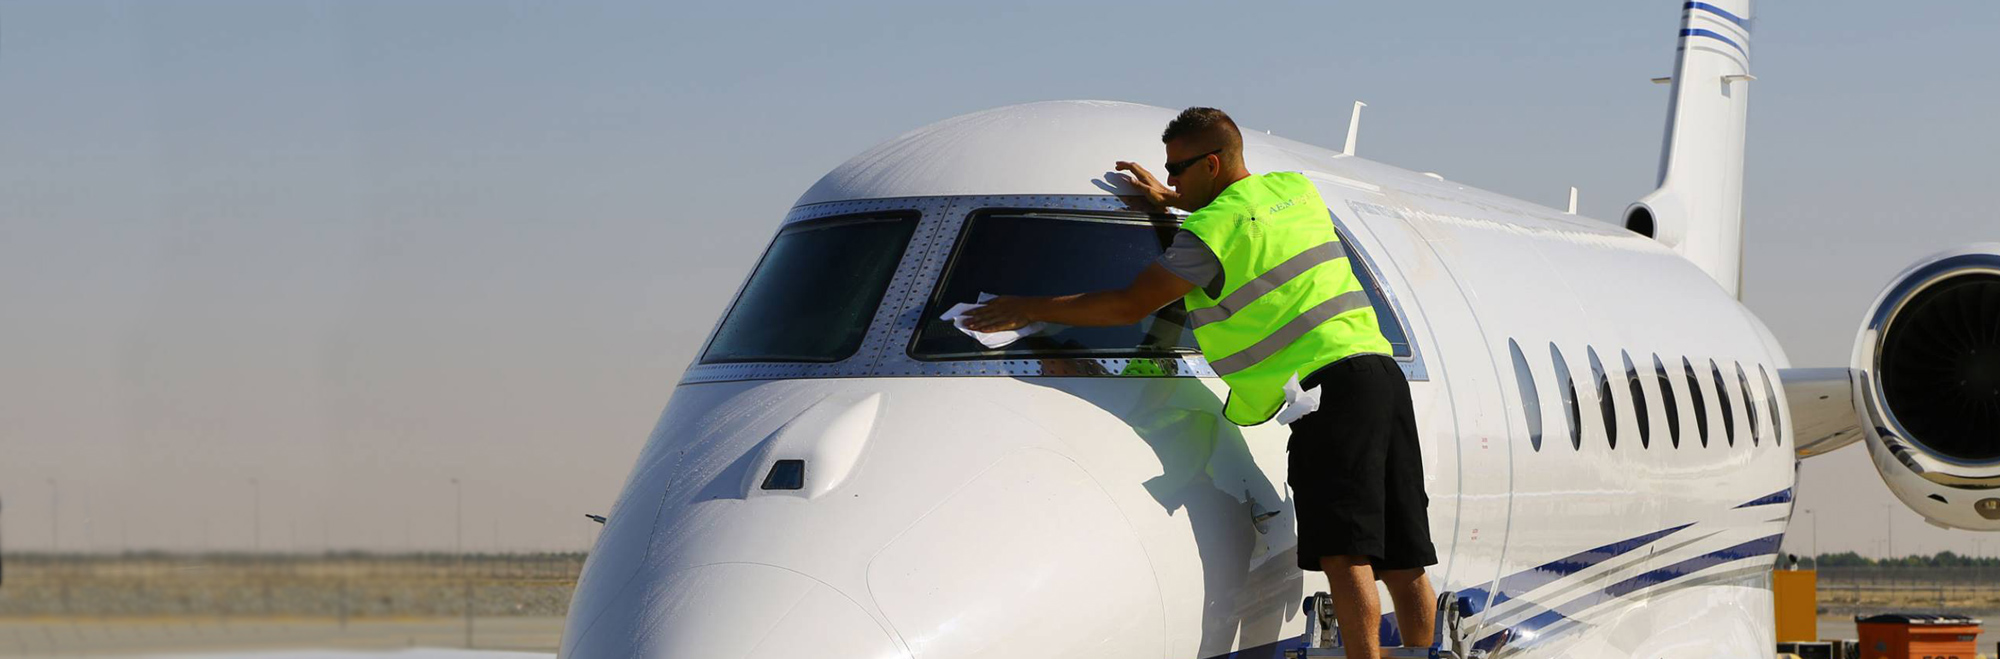

Data Wrangling and Clean up are vital parts of machine learning. Depending the situation, it's impossible to analyse data without manipulation. For that reason, we have to prepare the data in a way that makes it accessible for effective use further. In this notebook, we will focus mostly on this two process, the imputation of missing data must be treated separately and after the dataset is usable, however, given the nature of the dataset, some data will be imputated in the wrangling process.

# 1. Import Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('../input/aircraft-performance-dataset-aircraft-bluebook/Aiplane_BlueBook.csv')

df.head()

In [ ]:
df.info()

Important thing to note: there are only three categorical features (Model, Company, Engine type), but almost every feature is in the object format, which might be indicate that the feature might be on a non-conventional format for numerical data, such as strings, it must investigate further. For simplicity, let's change columns name for simpler ones. 

In [ ]:
df.rename(columns = {'HP or lbs thr ea engine': 'SHP/THR',
           'Max speed Knots': 'Vmax',
           'Rcmnd cruise Knots': 'Vcruise',
           'Stall Knots dirty': 'Vstall',
           'Fuel gal/lbs': 'FW',
           'All eng service ceiling': 'Hmax',
           'Eng out service ceiling': 'Hmax (One)',
           'All eng rate of climb': 'ROC',
           'Eng out rate of climb': 'ROC (One)',
           'Takeoff over 50ft': 'Vlo', 
           'Takeoff ground run': 'Slo', 
           'Landing over 50ft': 'Vl',
           'Landing ground roll': 'Sl',
           'Gross weight lbs': 'AUW',
           'Empty weight lbs': 'MEW',
           'Length ft/in': 'Length',
           'Height ft/in': 'Height',
           'Wing span ft/in': 'Wing Span',
           'Range N.M.': 'Range'}, inplace=True)

# 2. Third Party Modification Aircrafts

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull());

We can see from the heatmap that the observations with the least informations are the ones with missing engine type. Let's investigate further. 

In [ ]:
mask = df['Engine Type'].isnull()

df[mask].head()

In [ ]:
df[mask]['Company'].value_counts()

The missing information are from companies focused on modifying airplanes. Therefore, it was only informed the modifications for a given aiplane, all the missing data can be assumed as equal as the original. Rockwell Meyers 200 only have one instance and any information about their airplane, for this reason, we will drop it.

In [ ]:
df.drop(786, inplace = True)

mask = df['Engine Type'].isnull()

df[mask]

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[mask].isnull());

MEW attribute have a different format and interpretation, it indicates how much empty weight was added from the original airplane.

In [ ]:
plus_mew = df[mask]['MEW'].str.replace('+','', regex=False).astype(int)
df.loc[mask, 'MEW'] = np.nan

First, let's impute data from Cessna airplanes.

In [ ]:
df_aux = df[mask].copy()
df_aux = df_aux[~df[mask]['Model'].str.find('Cessna').astype(bool)]
mods = df_aux['Model'].str.replace('Cessna ', '', False)

mods

In [ ]:
list_cessna = df[df['Company'] == 'Cessna Aircraft Company']['Model'].to_list()
list_mods = mods.to_list()

dic = {}
for m in list_mods:
    for c in list_cessna:
        if c in m or m in c:
            dic[m] = c
dic

This method does not englobe all the modifications, the rest must be done manually.

In [ ]:
for c in list_cessna:
    if '421' in c:
        print(c)

In [ ]:
dic.update({'421,-A':'421 - A & B'})

for c in list_cessna:
    if '402' in c:
        print(c)

In [ ]:
dic.update({'402,-B; 401,-A': "402,-A turbocharged"})

lst = ['310', '337', '340']
for c in list_cessna:
    for l in lst:
        if l in c:
            print(c)

Note: Some modification names are general, and does not specify a airplane, Therefore, a airplane from the family was picked, but the correct procedure is to investigate from external sources how exactly is this modification, or take the mean value from a family instead of one instance.

In [ ]:
dic.update({'310 series':'310,-A',
            '337 (turbo, pressurized)': "T 337 C Skymaster turbocharged",
            '340, -A': '340 A, II pressurized/turbocharged'})

In [ ]:
for k,v in dic.items():
    mod = 'Cessna ' + k
    ind = df.loc[(df['Model'] == mod)].index
    orig = df.loc[df['Model'] == v, :].to_dict('records')[0]
    fillna = df.loc[ind, :].fillna(value=orig)
    df.loc[ind, :] = fillna

We will add another column, the Third Party modification indicator, as a Boolean.

In [ ]:
df['TP mods'] = False
df.loc[mask,'TP mods'] = True

Now, for Piper Aircraft and Beech:

In [ ]:
df_aux = df[mask].copy()
df_aux = df_aux[~df[mask]['Model'].str.find('Piper').astype(bool)]
mods = df_aux['Model'].str.replace('Piper ', '', False)

mods

In [ ]:
list_piper = df[df['Company'] == 'Piper Aircraft']['Model'].to_list()
list_mods = mods.to_list()

dic = {}
for m in list_mods:
    for c in list_cessna:
        if c in m or m in c:
            dic[m] = c
            
dic.update({'PA-23-250 Aztec': 'PA-23 C Aztec',
            'PA-34 Seneca I,II':'PA-34-200 C/R Seneca (1972)',
            'PA-30,-39':'PA-30 C Twin Comanche',
            'PA-32':"PA-32-260,C,D,E & '73 (c/s prop)",
    
})

for k,v in dic.items():
    mod = 'Piper ' + k
    ind = df.loc[(df['Model'] == mod)].index
    orig = df.loc[df['Model'] == v, :].to_dict('records')[0]
    fillna = df.loc[ind, :].fillna(value=orig)
    df.loc[ind, :] = fillna

In [ ]:
orig = 'V 35 A & B-TC Turbo Bonanza'
mod = 'Beech V35,A,B'

ind = df.loc[(df['Model'] == mod)].index
orig = df.loc[df['Model'] == v, :].to_dict('records')[0]
fillna = df.loc[ind, :].fillna(value=orig)
df.loc[ind, :] = fillna

df.loc[mask,'MEW'] = df.loc[mask,'MEW'].astype(int)

df.loc[mask,'MEW'] += plus_mew

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[mask].isnull());

With the exception of Hmax (One) and ROC (One), that we will explain further why, all data was imputated. But there's more modifications. They can be identified with the "Orig" term, that refers to the original.

In [ ]:
mask = (df == 'Orig').sum(axis=1).astype(bool)

df[mask]

df.loc[mask,'TP mods'] = True

df[mask]

Saving the columns to add weight and the ones to change, once MEW feature have different formats.

In [ ]:
plus_mew = df.loc[mask,'MEW'].str.replace('+','',regex=False)
plus_mew = plus_mew.str.replace('lb','',regex=False)
plus_mew = plus_mew.str.replace(' ','',regex=False)
plus_mew = plus_mew.str.replace('NC','0',regex=False)
plus_mew = plus_mew.fillna(0)
plus_mew = plus_mew.astype(int)
plus_mew.iloc[-2:] = 0
plus_mew[mask]

save_mew = df.loc[mask, 'MEW'].iloc[-2:]
df.loc[mask, 'MEW'] = np.nan

Changing column values to NaN.

In [ ]:
nans = ['Length', 'Height', 'Wing Span']

df.loc[mask, nans] = np.nan

In [ ]:
df.loc[mask & ((df['AUW'] == 'Orig') | (df['AUW'] == 'NC')), 'AUW'] = np.nan

In [ ]:
mask1 = df['Vmax'].apply(lambda x: '+' in str(x))

vmax_vcru_plus = df.loc[mask & mask1, ['Vmax', 'Vcruise']].copy()
df.loc[mask & mask1, ['Vmax', 'Vcruise']] = np.nan

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[mask].isnull());

For this change, I manually selected the airplanes, the string identification was getting more complex and I believed this was the most robust approach to go. Please share your thoughts down in the comments on how should I have approached this problem.

In [ ]:
df.loc[mask, 'Model']

In [ ]:
dic = {'Superstar II (600 series Aerostar)': 'PA-600,600A,-Aerostar',
       'Superstar I (601P Aerostar)': "PA-601P pressurized Aerostar ('77 service ceiling=26,350)",
       '350 Turbo A-36 Bonanza': 'A 36 Bonanza (300 hp)',
       '350 Turbo V-35B Bonanza': "V 35B Bonanza ('80 & up=fuel std 74 gal)",
       'RAM 421CW (W = winglets)': '421 pressurized/turbocharged',
       'RAM 414AW-IV (W = winglets)': "414A II Chancellor (pressurized-turbo) ('78 span=44/3)",
       'RAM 414AW-V (V = liquid-cooled)': "414A II Chancellor (pressurized-turbo) ('78 span=44/3)",
       'RAM 414AV-VII':"414A II Chancellor (pressurized-turbo) ('78 span=44/3)",
       'RAM 414A-VII (no winglets)': "414A II Chancellor (pressurized-turbo) ('78 span=44/3)",
       'RAM 414A-IV, III or Super Ram': "414A II Chancellor (pressurized-turbo) ('78 span=44/3)",
       'RAM 414-IV, III or Super Ram': '414 pressurized-turbocharged',
       'RAM 414-VI': '414 pressurized-turbocharged',
       'RAM 414-II (39" MP)': '414 pressurized-turbocharged',
       'RAM 340/340A-VI': '340 A, II pressurized/turbocharged',
       'RAM 340/340A-IV,III or Super Ram': '340 A, II pressurized/turbocharged',
       'RAM 340/340A-II (39" MP)': '340 A, II pressurized/turbocharged',
       'RAM CT310P,Q,R /320-IV':'T 310 P turbocharged',
       'RAM CT310P,Q,R /320-I':'T 310 P turbocharged',
       'RAM T310-IV (-P & -Q) / 320-IV':'T 310 P turbocharged',
       'RAM T310-I (-P & -Q)':'T 310 P turbocharged',
       'RAM T210 (G-J)':'T 210 G,H & J Turbo Centurion',
       'RAM T206-I (A-F)': 'T206H Turbo Stationair',
       "RAM 172 (1963-'76)": '172,-A',
       'RAM PA 28-140/151': 'PA-28 140 Cherokee Cruiser',
       'Jet Prop 421 C':"421C Golden Eagle III ('79 stall=85 mph)",
       'Jet Prop 421 (Cessna 421 conversion)': '421 pressurized/turbocharged',
       '414 Rocket (Cessna 414 conversion)': '414 pressurized-turbocharged',
       '340 Rocket (Cessna 340 conversion)': '340 pressurized/turbocharged',
       'Super 340 (Cessna 340 conversion)': '340 pressurized/turbocharged',
       'TurboStream (Cessna 310 & 320 conv) 350hp': '310,-A',
       'TurboStream (Cessna 310 & 320 conv) 310hp': '310,-A',
       'Turbo Rocket (Cessna 310 conversion)': '310,-A',
       'Rocket (Cessna 310 conversion)': '310,-A'}

for k,v in dic.items():
    ind = df.loc[(df['Model'] == k)].index
    orig = df.loc[df['Model'] == v, :].to_dict('records')[0]
    fillna = df.loc[ind, :].fillna(value=orig)
    df.loc[ind, :] = fillna

In [ ]:
vmax_vcru_plus['Vmax'] = vmax_vcru_plus['Vmax'].str.replace('+','', regex=False).astype(int)
vmax_vcru_plus['Vcruise'] = vmax_vcru_plus['Vcruise'].str.replace('+','', regex=False).astype(int)

In [ ]:
ind = vmax_vcru_plus.index

In [ ]:
df.loc[ind, ['Vmax', 'Vcruise']] = df.loc[ind, ['Vmax', 'Vcruise']].astype(int) 
df.loc[ind, ['Vmax', 'Vcruise']] += vmax_vcru_plus

In [ ]:
df.loc[ind, 'MEW'] = save_mew

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[mask].isnull());

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull());

# 3. Feature Format

In this section, we will focus on how the features are formatted and how we have to approach to give and representative numerical format for numerical features. 

## 3.1. Engine Type

In [ ]:
df['Engine Type'].value_counts()

We can easily reduce the cardinality of this feature, just by addressing if it's a Piston, a Jet or a Propjet.

In [ ]:
dic = {'piston': 'Piston',
       'PT6A-21': 'Propjet',
       'Pistion': 'Piston',
       'TSIO 520': 'Piston',
       'IO550': 'Piston',
       'PT6A-35': 'Propjet'}

for k, v in dic.items():
    df.loc[df['Engine Type'] == k, 'Engine Type'] = v

df['Engine Type'].value_counts()

In [ ]:
df.info()

As said before, some features are not corretly represented. Let's go throught then and understand why.

## 3.2. SHP/THR

In [ ]:
df['SHP/THR'] = df['SHP/THR'].astype(str)

mask = df['SHP/THR'].apply(lambda x: not x.isnumeric())

df[mask]

The non numeric attributes have a commentary on it. Let's change it.

In [ ]:
dic = {'940wet': 940,
       '1000 dry': 1000,
       '100 hp': 100,
       '717.5': 717.5}

for k, v in dic.items():
    df.loc[df['SHP/THR'] == k, 'SHP/THR'] = v
    
df['SHP/THR'] = df['SHP/THR'].apply(lambda x: float(x))

## 3.3. Vmax

In [ ]:
df['Vmax'] = df['Vmax'].astype(str)

mask = df['Vmax'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['Vmax']

Some instances are represented in Mach number, therefore it must be multiplied by the speed of sound. The last three ones have a +, but they are not modifications.

In [ ]:
def mach_to_kts(x):

    if 'mach' in x.lower():
        y = x.split(' ')[0]
        y = 667 * float(y)
        return y
    elif float(x) < 1:
        y = 667 * float(x)
        return y
    else:
        return x

df['Vmax'] = df['Vmax'].str.replace('+', '', regex=False)

df['Vmax'] = df['Vmax'].apply(mach_to_kts)

df['Vmax'] = df['Vmax'].apply(lambda x: float(x))

## 3.4. Vcruise

In [ ]:
df['Vcruise'] = df['Vcruise'].astype(str)

mask = df['Vcruise'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['Vcruise']

In [ ]:
def mach_to_kts(x):

    if 'mach' in x.lower():
        y = x.split(' ')[0]
        y = 667 * float(y)
        return y
    elif 'kts' in x.lower():
        y = x.split('k')[0]
        y = float(y)
        return y
    elif float(x) < 1:
        y = 667 * float(x)
        return y
    else:
        return x

df['Vcruise'] = df['Vcruise'].str.replace('+', '', regex=False)

df['Vcruise'] = df['Vcruise'].apply(mach_to_kts)

df['Vcruise'] = df['Vcruise'].apply(lambda x: float(x))

## 3.5. Vstall

In [ ]:
df['Vstall'] = df['Vstall'].astype(str)

mask = df['Vstall'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['Vstall']

In [ ]:
dic = {'84.5':84.5,
       '44kcas':44,
       '49kts':49}

for k, v in dic.items():
    df.loc[df['Vstall'] == k, 'Vstall'] = v

df['Vstall'] = df['Vstall'].apply(lambda x: float(x))

## 3.6. FW

In [ ]:
df['FW'] = df['FW'].astype(str)

mask = df['FW'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['FW']

## 3.7. Hmax (One)

In [ ]:
df['Hmax (One)'] = df['Hmax (One)'].astype(str)

mask = df['Hmax (One)'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['Hmax (One)']

In [ ]:
def conversor(x):

    if 'fwd' in x.lower():
        y = x.split(' ')[1]
        y1, y2 = y.split(',')
        y = 1000 * float(y1) + float(y2)
        return y
    elif 'f' in x.lower():
        x = x[1:]
        y1, y2 = x.split(',')
        y = 1000 * float(y1) + float(y2)
        return y
    else:
        return x

df['Hmax (One)'] = df['Hmax (One)'].apply(conversor)

df['Hmax (One)'] = df['Hmax (One)'].apply(lambda x: float(x))

## 3.8. ROC

In [ ]:
df['ROC'] = df['ROC'].astype(str)

mask = df['ROC'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['ROC']

In [ ]:
def conversor(x):

    if '3bld' in x.lower():
        y = x.split(' ')[0]
        y1, y2 = y.split(',')
        y = 1000 * float(y1) + float(y2)
        return y
    else:
        return x

df['ROC'] = df['ROC'].apply(conversor)

df['ROC'] = df['ROC'].apply(lambda x: float(x))

## 3.9. ROC (One)

In [ ]:
df['ROC (One)'] = df['ROC (One)'].astype(str)

mask = df['ROC (One)'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['ROC (One)']

In [ ]:
def conversor(x):
    if 'f' in x.lower():
        y = x[1:]
        return float(y)
    else:
        return x

df['ROC (One)'] = df['ROC (One)'].apply(conversor)

df['ROC (One)'] = df['ROC (One)'].apply(lambda x: float(x))

## 3.10. AUW

In [ ]:
df['AUW'] = df['AUW'].astype(str)

mask = df['AUW'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['AUW']

## 3.11. MEW

In [ ]:
df['MEW'] = df['MEW'].astype(str)

mask = df['MEW'].apply(lambda x: not x.isnumeric() and x != 'nan')

df[mask]['MEW']

In [ ]:
df.loc[mask, 'MEW'] = df.loc[mask, 'MEW'].apply(lambda x: 1000 * float(x))

df.loc['MEW'] = df['MEW'].apply(lambda x: float(x))

## 3.12. Range

In [ ]:
df['Range'] = df['Range'].astype(str)

mask = df['Range'].apply(lambda x: not x.isnumeric() and x != 'nan')

df.loc[mask,'Range']

In [ ]:
dic = {'1,000+':1000,
       '600nm':600}

for k, v in dic.items():
    df.loc[df['Range'] == k, 'Range'] = v

df['Range'] = df['Range'].apply(lambda x: float(x))
    
df[mask]['Range']

## 3.13. Length

In [ ]:
df['Length'] = df['Length'].astype(str)

mask1 = df['Length'].apply(lambda x: x.isnumeric() and x != 'nan')

df.loc[mask1] 

In [ ]:
df.loc[df['Model'] == "G164B-525 (design-sprayer) prior'78=25/11 length", 'Length'] = '25/11'
df.loc[df['Length'] == 'N/C', 'Length'] = 'nan'


mask0 = df['Length'].apply(lambda x: not x.isnumeric() and x != 'nan')

def conversor(x):
    y1, y2 = x.split('/')
    
    return float(y1) + float(y2)/12

df.loc[mask0, 'Length'] = df.loc[mask0, 'Length'].apply(conversor)

df['Length'] = df['Length'].apply(lambda x: float(x))

## 3.14. Height

In [ ]:
df['Height'] = df['Height'].astype(str)

mask1 = df['Height'].apply(lambda x: x.isnumeric() and x != 'nan')

df.loc[mask1] 

In [ ]:
df.loc[df['Height'] == 'N/C', 'Height'] = 'nan'

mask0 = df['Height'].apply(lambda x: not x.isnumeric() and x != 'nan')

def conversor(x):
    y1, y2 = x.split('/')
    
    return float(y1) + float(y2)/12

df.loc[mask0, 'Height'] = df.loc[mask0, 'Height'].apply(conversor)

df['Height'] = df['Height'].apply(lambda x: float(x))

## 3.15. Wing Span

In [ ]:
df['Wing Span'] = df['Wing Span'].astype(str)

mask1 = df['Wing Span'].apply(lambda x: x.isnumeric() and x != 'nan')

df.loc[mask1,'Wing Span'] 

In [ ]:
df.loc[df['Wing Span'] == 'N/C', 'Wing Span'] = 'nan'

mask0 = df['Wing Span'].apply(lambda x: not x.isnumeric() and x != 'nan')

def conversor(x):
    if '.' not in x:
        y1, y2 = x.split('/')
        return float(y1) + float(y2)/12
    else:
        return x

df.loc[mask0, 'Wing Span'] = df.loc[mask0, 'Wing Span'].apply(conversor)

df['Wing Span'] = df['Wing Span'].apply(lambda x: float(x))

In [ ]:
list_convert = df.drop(['Model', 'Company', 'Engine Type', 'TP mods'], axis=1).columns.to_list()

for lst in list_convert:
    df[lst] = df[lst].astype(float)
    
df['TP mods'] = df['TP mods'].astype(bool)

df = df.iloc[:-1,:]

df.info()

Now, the numeric features can be used for data analysis.

# 4. Feature Units

We have to feature with different units, the `SHP/THR` (hp/lb) and `FW` (gals/lb). For engine performance, Shaft Horsepower is only applied to Propeller-driven airplanes, [it does not make sense specify to jets](https://code7700.com/aero_thrust_vs_power.htm). The opposite occurs to Turbo-driven aiplanes, where the thrust must be specified. For Propeller-driven airplanes, you must specifiy the propeller to use, and even then your thrust might not be constant.

In [ ]:
df['THR'] = np.nan
df['SHP'] = np.nan
df.loc[df['Engine Type'] == 'Jet', 'THR'] = df.loc[df['Engine Type'] == 'Jet', 'SHP/THR']
df.loc[df['Engine Type'].isin(['Propjet', 'Piston']), 'SHP'] = df.loc[df['Engine Type'].isin(['Propjet', 'Piston']), 'SHP/THR']

df.drop('SHP/THR', axis=1, inplace = True)

As for Fuel Weight, some instances are specified in volume (gallons). To convert, we must multiply by [6.7 lb/USgal](http://https://en.wikipedia.org/wiki/Aviation_fuel). The problem is identify which instances are described as gallons. We can, however, know which istances are more reasonable. We can approximate AUW values by summing MEW and FW, the approach with less absolute error is more likely to be correct.

In [ ]:
df[(df['AUW'] - df['MEW']) < 0]

In [ ]:
df[(df['AUW'] - df['MEW']) < 0][['AUW', 'MEW']]

G164B-525 correct AUW and MEW are [3150 and 2680 lb respectively](https://en.wikipedia.org/wiki/Grumman_Ag_Cat).

In [ ]:
df.loc[(df['AUW'] - df['MEW']) < 0, 'AUW'] = 3150 
df.loc[(df['AUW'] - df['MEW']) < 0, 'MEW'] = 2680

In [ ]:
df['Error1'] = np.abs(df['AUW'] - (df['MEW'] + df['FW']))
df['Error2'] = np.abs(df['AUW'] - (df['MEW'] + 6.7*df['FW']))

df['FWt'] = np.abs(df['AUW'] - df['MEW'])

gals = df['Error1'] > df['Error2']

df['Unit'] = gals

df.loc[gals == True, 'Unit'] = 'gals'
df.loc[gals == False, 'Unit'] = 'lb'

In [ ]:
plt.figure(figsize=(12, 6))
sns.lmplot(data=df, x='FW', y='FWt', palette='rocket', hue='Unit');

The instances classified as gals will be multiplied by 6.7.

In [ ]:
df.loc[df['Unit'] == 'gals', 'FW'] *= 6.7

Let's if there's any exception:

In [ ]:
df.loc[(df['FW'] < 100.), ['FW', 'MEW', 'AUW']]

Some values are missing, therefore, the classification is not possible. We will change for this instances.

In [ ]:
df.loc[df['Unit'] == 'gals', 'FW'] /= 6.7

df.loc[(df['FW'] < 100.) & (df['MEW'].isnull()), 'Unit'] = 'gals'

df.loc[df['Unit'] == 'gals', 'FW'] *= 6.7

In [ ]:
df.drop(['Error1', 'Error2', 'Unit', 'FWt'], axis=1, inplace=True)

# 5. Checking Errors

Now, we will check if there wrong values in the dataset.

In [ ]:
for c in df.columns:
    if c not in ['Model', 'Company', 'Engine Type', 'TP mods']:
        plt.figure(figsize=(12, 6))
        sns.histplot(data=df, x=c)

In [ ]:
print(df.loc[df['Slo'] > 4e4]['Slo'])
df.loc[df['Slo'] > 4e4]

Praetor 500 correct take-off distance is [4222 ft](https://en.wikipedia.org/wiki/Embraer_Legacy_450/500_and_Praetor_500/600).

In [ ]:
df.loc[df['Range'] >1e4]

G500 correct range is [5200 nm](https://en.wikipedia.org/wiki/Gulfstream_G400/G500/G600).

In [ ]:
df.loc[df['Slo'] > 4e4, 'Slo'] = 4222.
df.loc[df['Range'] >1e4, 'Range'] = 5200.

## 6. Multi Engine

Some airplanes from this dataset are multi engine, but there is no information about it. This is crucial, and we can't consider using engine specifications without . I believe there's only mono and bi engine planes in this dataset, but we have to investigate this more carefully. For now, let's just consider if they are multi or mono engine airplanes. The only way is to consider information regarding Hmax (One) and ROC (One), since if its values are different from the normal, its multi engine. The large amount of missing values from this two features might be explained by the fact that large part of this dataset is mono engine, but it might be lack of information on the feature also.

In [ ]:
mask1 = (df['Hmax'] != df['Hmax (One)']) & (~df['Hmax (One)'].isnull())
mask2 = (df['ROC'] != df['ROC (One)']) & (~df['ROC (One)'].isnull())

df['Multi Engine'] = np.nan
df.loc[mask1 | mask2, 'Multi Engine'] = True

In [ ]:
order = ['Model', 'Company', 'Engine Type','Multi Engine', 'TP mods',
 'THR', 'SHP', 'Length', 'Height', 'Wing Span', 'FW', 'MEW', 'AUW',
 'Vmax', 'Vcruise', 'Vstall', 'Hmax', 'Hmax (One)', 'ROC', 'ROC (One)',
 'Vlo', 'Slo', 'Vl', 'Sl',  'Range']


df = df[order]

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull());

# 7. Conclusions

There's more things to do to improve this dataset, like:

* Impute missing data;
* Define if the airplanes are multi engine or not;
* Predict the number of engines;
* Retrieve information from model's name;

But regardless, the dataset now can be used for data analysis and data science. Please upvote if like it and share your thoughts down in the comments. Thank you for reading it.

In [ ]:
df.to_csv('Airplane_Cleaned.csv', index=False)